# VODAFONE CHALLENGE ~ Group 12
### Camilla Cestaro, Gian Marco Sorarù,  Luca Mingardi, Muhammad Talha Bin Ijaz, Rodolphe Royer de la Bastie




# READ ME

Make sure to follow all of the below commands before running the code:
- Be sure to keep the files all in the same folder.
- If an error arises during the Visualizations, make sure to have installed statsmodels through the command "pip install statsmodels" .
- Install Tensorflow through the command line using "pip install tensorflow".


# APPROACH TO CHALLENGE 

Welcome to our Vodafone project. 

Our group of 5 BEMACS students have worked with determination to give our best solution to this data science problem. 

The journey was filled with long coding sessions, neverending group meetings and many very creative ways to approach this problem.

We are proud to see where this project has lead us and are convinced you will appreciate the effort put into this presentation.

We hope going through this notebook will be a clear and smooth experience.

Enjoy the journey.

# PIPELINE

### 1 Data Cleaning 
### 2 Data Visualization
### 3 Machine Learning 
### 4 Conclusions

# 1. DATA CLEANING & PREPARATION

For the data cleaning we started off with the original raw data set provided by Vodafone. We worked step by step focusing on the main issues we thought were most important to achieve a clean and complete dataframe.
Below we added descriptions to every function for the cleaning.
At the end we have added a "__main__" function which implements all the cleaning.

### Imports 

In [173]:
import pandas as pd
import numpy as np
import random as rnd
import random
from collections import Counter

# Data visualization
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf


In the next cell we define an element called "total", which contains all the columns from the dataset we were given, excluding the first one from the dataset (which simply enumerated the users).

In [174]:
total = ['Product', 'CustomerAge', 'DataAllowance', 'DataArpu', 
            'DeviceFlag4G', 'DeviceFlagSmartphone', 'MonthlyDataTraffic','MonthlyVoiceTrafficCount',
            'CustomerGender', 'CustomerImmigrant','DevicePrice', 'MonthlySmsTrafficCount', 'ZipCode',
            'DeviceOperatingSystem', 'File-Transfer', 'Games','Instant-Messaging-Applications', 
            'Mail', 'Music-Streaming','Network-Operation', 'P2P-Applications', 'Security', 
            'Streaming-Applications','Terminals', 'Unclassified', 'VoIP', 'Web-Applications']

__"get_Y"__ defines a Y variable that is  based on the product purchased by the user. 
This function returns Y, in the form of a one hot representation:  it returns 1 in the position specified by the function, and 0 in all other positions.

For example, if user 1 bought a V-Bag, then his list would be [0,1,0,0], and so on for every user.

In [175]:
def get_Y(df):
    y = df["Product"]  # {'V-Camera'(0), 'V-Bag'(1), 'V-Auto'(2),'V-Pet'(3)}
    def f(x):
        if(x == "V-Camera"): return 0
        if(x == "V-Bag"): return 1
        if(x == "V-Auto"): return 2
        if(x == "V-Pet"): return 3
    y = y.apply(f).as_matrix()
    Y = np.zeros((y.shape[0],4))
    Y[np.arange(y.shape[0]), y] = 1
    
    y=np.argmax(Y, axis=1)
    df["Product"] = y
    
    return Y, df

__"fix_CustomerAge"__ deals with CustomerAge column. Noticing that by construction the  CustomerAge column was provided in the form of intervals, we decided to take the average of the two extremes given. 

Because the maximum value for age in the dataset is 85, we decided to rescale the values between 0 and 1, with 1 corresponding to the maximum age and 0 to the minimum age. 

Finally, we replaced the new rescaled values in the CustomerAge column. 

Notice that we have not dealt with the issue of missing values (NaN) in this part.

In [176]:
def fix_CustomerAge(df):
    def f(x):
        x=str(x)
        if("nan" not in x):
            x = x[1:-1].split(", ")
            age = (int(x[0])+int(x[1]))/170
            return age
    df['CustomerAge'] = df['CustomerAge'].apply(f)
    
    return df

__"fix_DeviceOperatingSystem"__ deals with the Device Operating System column. We first created 3 new categories: Android, iOS, and Other. We thought that the number of other operating systems was not significant, hence we grouped them together as a single category: Other. 

We then created a One Hot Vector which assigns each user to one of the 3 categories.

To fill in the missing values, we assigned at random one category, based on how the data was distributed. We uniformly generated a random number between 0 and 1, and divided the range into the 3 possile outcomes, android having the highest probability and the other OS's having least.

In [177]:
def fix_DeviceOperatingSystem(df):
    df['Android'] = np.zeros((df.shape[0],1)).flatten()
    df['iOS'] = np.zeros((df.shape[0],1)).flatten()
    df['Other OS'] = np.zeros((df.shape[0],1)).flatten()

    def f(x):
        os = str(x['DeviceOperatingSystem'])
        if ("nan" not in os):
            if(os=='Android'): x['Android'] = 1.0
            elif (os == 'iOS'): x['iOS'] = 1.0
            else : x["Other OS"] = 1.0
        else:
            i = random.random()
            if(i<0.5895): x['Android'] = 1.0
            elif(i<0.9827): x['iOS'] = 1.0
            else: x["Other OS"] = 1.0
        
        return x
    
    df = df.apply(f, axis=1)
    df = df.drop(["DeviceOperatingSystem"], axis=1)
    
    return df

__"Make_density"__ creates 3 new columns corresponding to a 3 dimensional One Hot Vector.

We webscraped the population densities of every zipcode in italy and stored them in a dictionary. 

We defined 3 categories: "Rural", "SemiUrban", "Urban". We grouped the zipcodes based on how densely populated the area is.

A population density of below 300 inhabitants per square km corresponds to the "Rural" Category. <br>
A population density of below 300 and 1900 inhabitants per square km corresponds to the "SemiUrban" Category. <br>
A population density of above 1900 inhabitants per square km corresponds to the "Urban" Category.

In [178]:
def make_density(df):
    density = np.load("density.npy").item()
    zipcode_density = np.load("zipcode_density.npy").item()

    df['Urban'] = np.zeros((df.shape[0], 1)).flatten()
    df['SemiUrban'] = np.zeros((df.shape[0], 1)).flatten()
    df['Rural'] = np.zeros((df.shape[0], 1)).flatten()

    def f(x):
        try: x["Density"]  = zipcode_density[x["ZipCode"]]
        except: x["Density"] = density[x["Province"]]
        if(x["Density"]<=300):    x['Rural'] = 1.0
        elif(x["Density"]<=1900): x['SemiUrban'] = 1.0
        else:                     x['Urban'] = 1.0
        
        return x
    
    df = df.apply(f, axis=1)
    
    return df

__"make_gdp"__ Based on the region of each user we found  the local gdp per capita.

We scaled it from 0 to 1, 1 being the richest and 0 being the poorest.

We created a new column that we add to the data set, containing the gdp per capita.

In [179]:
def make_gdp(df):
    gdp = np.load("gdp_s.npy").item()
    def f(x):
        if(str(x["Region"])=="nan"): return x
        x["Gdp"] = gdp[x["Region"]]
        return x
    df = df.apply(f, axis=1)
    
    return df

__"make_location"__ Divides the country into 5 main regions: NorthEast, NorthWest, Center, South and Island. The function creates 5 new columns corresponding to a 5 dimensional One Hot Vector. Each user is then assigned to one of the 5 regions.

In [180]:
def make_location(df):
    # NorthEast: -1, NorthWest: 0 Center: 1, South: 2, Island: 3
    location = np.load("location.npy").item()

    df["NorthEast"] = np.zeros((df.shape[0],1)).flatten()
    df["NorthWest"] = np.zeros((df.shape[0], 1)).flatten()
    df["Center"] = np.zeros((df.shape[0],1)).flatten()
    df["South"] = np.zeros((df.shape[0],1)).flatten()
    df["Islands"] = np.zeros((df.shape[0], 1)).flatten()

    def f(x):
        if(str(x["Region"])=="nan"): return x
        elif (location[x["Region"]] == -1): x["NorthEast"] = 1.0
        elif(location[x["Region"]]==0): x["NorthWest"] = 1.0
        elif(location[x["Region"]]==1): x["Center"] = 1.0
        elif (location[x["Region"]] == 2): x["South"] = 1.0
        elif (location[x["Region"]] == 3): x["Islands"] = 1.0
        return x
    df = df.apply(f, axis=1)
    
    return df

__"fix_ZipCode"__ modifies the original format of the zipcodes. It returns the same column but the zipcodes are now in the standard format to be used for data analysis.

In [181]:
def fix_ZipCode(df):
    def f(x):
        if (str(x) == "nan"): return x
        x = str(int(x))
        for i in range(5-len(x)): x="0"+x
        return x
    df["ZipCode"] = df["ZipCode"].apply(f)
    
    return df

__"make_shops"__ This function takes as an input a file containg a dataset of all the Vodafone Stores in Italy which we obtained through webscraping. The function identifies the number of stores present near a user based on the zipcode.

In [182]:
def make_shops(df):
    shops = np.load("shops.npy").item()
    def f(x):
        if ("nan" in str(x["ZipCode"])): return x
        else:
            try:
                if(shops[x["ZipCode"]]>=4): x["Shops"] = 1.0
                else:                       x["Shops"] = shops[x["ZipCode"]]/4
            except: x["Shops"] = 0.0
            return x
    df = df.apply(f, axis=1)

    return df

__"remove_nans_CustomerAge"__ Fills in the NaN values of the CustomerAge column. 

We decided to fill them in with the averages of each gender.

In [183]:
def remove_nans_CustomerAge(df):
    male_avg = 0.53519028
    female_avg = 0.52472219
    def f(x):
        if(str(x["CustomerAge"]) in "nan"):
            if(x["CustomerGender"]==1): x["CustomerAge"] = male_avg
            elif(x["CustomerGender"]==0): x["CustomerAge"] = female_avg
        return x
    df = df.apply(f, axis=1)
    
    return df

__"remove_nans_DataArpu"__ Fills in the NaN values of the DataArpu column.

It is done using linear regression.

In [184]:
def remove_nans_DataArpu(df):
    # X = "DataAllowance"
    # Coef: 0.25304055 ; Y_intercept: 0.10605818
    def f(x):
        if ("nan" in str(x["DataArpu"])):
            x["DataArpu"] = 0.25304055*x["DataAllowance"] + 0.10605818
        return x
    df = df.apply(f, axis=1)
    
    return df

__"remove_nans_DataAllowance"__ Fills in the NaN values of the DataAllowance column.

It is done using linear regression.

In [185]:
def remove_nans_DataAllowance(df):
    # X = "MonthlyDataTraffic", "MonthlyVoiceTrafficCount", "MonthlySmsTrafficCount"
    # Coef: 0.62421567, 0.02758238, 0.03996504 ; Y_intercept: 0.17282045
    def f(x):
        if ("nan" in str(x["DataAllowance"])):
            x["DataAllowance"] =0.62421567*x["MonthlyDataTraffic"] + 0.02758238*x["MonthlyVoiceTrafficCount"] + 0.03996504*x["MonthlySmsTrafficCount"] + 0.17282045
        return x
    df = df.apply(f, axis=1)
    
    return df

__"remove_nans_ZipCode"__  Fills in the NaN values of the ZipCode column.

We selected the most common zipcodes and put them in a list. We then picked one at random and assigned it to the user with a missing value.

In [186]:
def remove_nans_ZipCode(df):
    
    common = ['71121', '20090', '20010', '85100', '20146', '00012', '43122', '00172', '80126', '00040', '29010',
              '22100', '71122', '88046', '07100', '58100', '76123', '54100', '95030', '26100', '31100', '20144',
              '74016', '41012', '12051', '17100', '24060', '55100', '37138', '36100', '00054', '24020', '55047',
              '00159', '10070', '03100', '27029', '20811', '10024', '00168', '81100', '95024', '10020', '21040',
              '70056', '88100', '21047', '10073', '00134', '18038', '37069', '27025', '21100', '43125', '67100',
              '66020', '30174', '00019', '15121', '00167', '71121', '64100', '67039', '16152', '04100', '80010',
              '20063', '26013', '21052', '15010', '00125', '32030', '20123', '89129', '00176', '20833', '84121',
              '11100', '07021', '00053', '50050', '38010', '80065', '18010', '00198', '04026', '00175', '54033',
              '46029', '30016', '21051', '40138', '00010', '22036', '10153', '23100', '07026', '16134', '28100',
              '10036', '20147', '10139', '20080', '80078', '59100', '53100', '00199', '10042', '72100', '70022',
              '00124', '87064', '80026', '00139', '00015', '38123', '39100', '00179', '37059', '00177', '70121',
              '87100', '09123', '43123', '10022', '47521', '00135', '00128', '46100', '20091', '70010', '15060',
              '10060', '40131', '16156', '10090', '80055', '21013', '55049', '32032', '00153', '80131', '22040',
              '10040', '76011', '20861', '20136', '15076', '71036', '66054', '09134', '58023', '10149', '06056',
              '80014', '12042', '20131', '16132', '20851', '40139', '80129', '09127', '10072', '36016', '23023',
              '10143', '37011', '20017', '00049', '22030', '21030', '37060', '14055', '30173', '31050', '00132',
              '37057', '67046', '70019', '20812', '40124', '84091', '10043', '41019', '64028', '87032', '57125',
              '36010', '28923', '50059', '37135', '84131', '09041', '72022', '83031', '20151', '08020', '81030',
              '37017', '36061']

    def f(x):
        if("nan" in str(x["ZipCode"])):
            x["ZipCode"] = random.choice(common)
        return x
    df = df.apply(f, axis = 1)
    
    return df

__"get_province_region_from_zipcode"__ The function fills in the missing values of province and region by using the zipcodes. 

For the missing values, we picked at random one province from the list.

In [187]:
def get_province_region_from_zipcode(df):
    zipcode_province = np.load("zipcode_province.npy").item()
    province_region = np.load("province_region.npy").item()
    provinces = ['TARANTO', 'LATINA', 'BRESCIA', 'REGGIO DI CALABRIA', 'NAPOLI', 'POTENZA', "L'AQUILA", 'SIENA',
                'CHIETI', 'BERGAMO', 'BELLUNO', 'BARLETTA-ANDRIA-TRANI', 'CAMPOBASSO', 'VARESE', 'PISA', 'PALERMO',
                'LA SPEZIA', 'MONZA E BRIANZA', 'PARMA', 'ROVIGO', 'CAGLIARI', "REGGIO NELL'EMILIA", 'PRATO', "VALLE D'AOSTA",
                 'NUORO', 'BOLOGNA', 'MATERA', 'VERBANO-CUSIO-OSSOLA', 'SALERNO', 'MILANO', 'GORIZIA', 'COMO', 'TRAPANI',
                 'UDINE', 'TRIESTE', 'MASSA-CARRARA', 'PESARO E URBINO', 'CATANZARO', 'MEDIO CAMPIDANO', 'CUNEO', 'LECCO',
                 'SIRACUSA', 'PISTOIA', 'SASSARI', 'PORDENONE', 'MODENA', 'FROSINONE', 'MACERATA', 'ALESSANDRIA', 'GROSSETO',
                 'AVELLINO', 'MANTOVA', 'RAGUSA', 'TERAMO', 'SONDRIO', 'TREVISO', 'RIMINI', 'OLBIA-TEMPIO', 'VERONA', 'ISERNIA',
                 'FOGGIA', 'LECCE', 'RAVENNA', 'CASERTA', 'ORISTANO', 'TRENTO', 'AREZZO', 'PESCARA', 'CATANIA', 'TERNI',
                 'BRINDISI', 'LODI', 'ROMA', 'VENEZIA', 'CREMONA', 'CALTANISSETTA', 'ASTI', 'BENEVENTO', 'FORLI', 'SAVONA',
                 'FIRENZE', 'TORINO', 'VIBO VALENTIA', 'NOVARA', 'CARBONIA-IGLESIAS', 'VICENZA', 'BOLZANO-BOZEN', 'FERMO', 'MESSINA',
                 'BIELLA', 'GENOVA', 'BARI', 'PERUGIA', 'PIACENZA', 'VERCELLI', 'LUCCA', 'COSENZA', 'RIETI', 'FERRARA', 'PAVIA',
                 'IMPERIA', 'PADOVA', 'LIVORNO', 'VITERBO', 'AGRIGENTO', 'CROTONE', 'ASCOLI PICENO', 'ANCONA']

    def f(x):
        if("nan" in str(x["Province"])):
            try:    province = zipcode_province[x["ZipCode"]]
            except: province = random.choice(provinces)
            x["Province"] = province
            x["Region"] = province_region[province]  #
        
        return x

    df  = df.apply(f, axis=1)

    return df

__"remove_other_nans"__ Replaces the NaN values in the columns we have not considered yet, with the average of each column.

In [188]:
def remove_other_nans(df):
    #Replace nans with the respective averages
    MonthlyVoiceTrafficCount_avg = 0.108776475955
    MonthlySmsTrafficCount_avg = 0.002014
    MonthlyDataTraffic_avg = 0.0557599391181


    df["MonthlyVoiceTrafficCount"] = df["MonthlyVoiceTrafficCount"].fillna(MonthlyVoiceTrafficCount_avg)
    df["MonthlySmsTrafficCount"] = df["MonthlySmsTrafficCount"].fillna(MonthlySmsTrafficCount_avg)
    df["MonthlyDataTraffic"] = df["MonthlyDataTraffic"].fillna(MonthlyDataTraffic_avg)

    return df

__"remove_with_more_nans"__ This function deletes the rows (users) with too many missing values.

In [189]:
def remove_with_more_nans(df,n = 4):
    null = np.sum(df.isnull().as_matrix(), axis=1)
    inds = np.argwhere(null>=n).flatten().tolist()
    df = df.drop(df.index[inds])
    return df

## Main Function

This is the __"main"__ function. It cleans the initial data set by calling all of the functions we have defined above.

Y is the product purchased by each user. 

We reordered the columns of the dataframe, in order to make it easier to work with.

We saved Y as a separate npy file, so that we can use it with our algorithm.

For correct functioning it is important to keep all the attached files (dictionaries, cvs) in the same folder. <br>

In [190]:
def main():
    df = pd.read_csv("dataset_challenge_v5.TRAINING.csv")
    df = remove_with_more_nans(df, n=8)
    
    if("Product" in list(df.columns.values)): y_in_df = True
    else: y_in_df = False
    
    print(y_in_df)

    if(y_in_df): Y, df = get_Y(df)
    else: Y = None
    #Y = np.argmax(Y, axis=1).reshape(-1, 1)

    df = fix_ZipCode(df)
    df = remove_nans_ZipCode(df)
    df = get_province_region_from_zipcode(df)
    df = fix_CustomerAge(df)
    df = fix_DeviceOperatingSystem(df)
    df = make_density(df)
    df = make_gdp(df)
    df = make_location(df)
    df = make_shops(df)
    df = remove_other_nans(df)
    df = remove_nans_CustomerAge(df)
    df = remove_nans_DataAllowance(df)
    df = remove_nans_DataArpu(df)

    columns_required = ['Product','CustomerAge', 'CustomerGender', 'CustomerImmigrant', 'DataAllowance', 'DataArpu', 'DeviceFlag4G',
                        'DeviceFlagSmartphone' , 'iOS', 'Android', 'Other OS', 'Gdp', 'Shops', 'Urban', 'SemiUrban', 'Rural',
                        'NorthEast', 'NorthWest', 'Center', 'South', 'Islands',
                        'File-Transfer', 'Games', 'Instant-Messaging-Applications', 'Mail', 'MonthlyDataTraffic',
                        'MonthlySmsTrafficCount', 'MonthlyVoiceTrafficCount','Music-Streaming', 'Network-Operation', 'P2P-Applications',
                        'Security','Streaming-Applications','Terminals', 'Unclassified', 'VoIP', 'Web-Applications']
    df = df[columns_required]

    return df, Y

In [191]:
df, Y = main()

True


# 2. DATA VISUALIZATION

Before working on a clean dataset it is always a good idea to get a first glimpse of how the data is spread out. <br>

In this section we wanted to get an overview of the most important characteristics of our dataframe. <br>
Plotting different attributes is a way to visually verify the presence of any outliers or impossible data values (negative age).

## Data Description

In [192]:
df.head(10)

,Product,CustomerAge,CustomerGender,CustomerImmigrant,DataAllowance,DataArpu,DeviceFlag4G,DeviceFlagSmartphone,iOS,Android,...,MonthlyVoiceTrafficCount,Music-Streaming,Network-Operation,P2P-Applications,Security,Streaming-Applications,Terminals,Unclassified,VoIP,Web-Applications
0,1,1.000000,0.0,0.0,0.239013,0.023735,0.0,1.0,1.0,0.0,...,0.156938,0.003853,0.000936,5.491870e-08,0.002637,0.550123,0.0,0.000301,0.000773,0.291156
1,2,0.764706,1.0,0.0,0.239013,0.118674,0.0,1.0,0.0,1.0,...,0.053965,0.000000,0.000000,0.000000e+00,0.001790,0.010782,0.0,0.026300,0.011175,0.632345
2,2,0.411765,0.0,0.0,0.095605,0.178010,1.0,1.0,0.0,1.0,...,0.039923,0.000001,0.000005,2.395075e-05,0.029518,0.372174,0.0,0.011640,0.002848,0.503553
3,1,0.882353,1.0,0.0,0.119507,0.249070,0.0,0.0,1.0,0.0,...,0.147852,0.069575,0.016854,0.000000e+00,0.005859,0.134255,0.0,0.003630,0.000030,0.431561
4,3,0.411765,1.0,0.0,0.289900,0.083072,0.0,0.0,1.0,0.0,...,0.064152,0.006521,0.001321,7.058996e-05,0.001687,0.327205,0.0,0.000151,0.000748,0.640527
5,1,0.647059,1.0,0.0,0.024672,0.076564,0.0,1.0,1.0,0.0,...,0.107654,0.006426,0.001967,3.625449e-05,0.008794,0.540695,0.0,0.003318,0.006316,0.349410
6,3,0.529412,1.0,0.0,0.239013,0.083072,0.0,1.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.001674,0.0,0.005731,0.004340,0.960524
7,2,0.764706,1.0,0.0,0.047803,0.142408,0.0,1.0,0.0,1.0,...,0.033866,0.000000,0.000000,0.000000e+00,0.000000,0.038692,0.0,0.004357,0.008780,0.902594
8,3,0.411765,0.0,0.0,0.138782,0.213468,1.0,1.0,0.0,1.0,...,0.061399,0.000000,0.000000,0.000000e+00,0.007981,0.227982,0.0,0.001489,0.003940,0.682028
9,1,0.647059,0.0,0.0,0.268311,0.284817,1.0,1.0,1.0,0.0,...,0.001101,0.087451,0.003384,0.000000e+00,0.000000,0.000540,0.0,0.002146,0.000000,0.299262


In [193]:
df.describe()

,Product,CustomerAge,CustomerGender,CustomerImmigrant,DataAllowance,DataArpu,DeviceFlag4G,DeviceFlagSmartphone,iOS,Android,...,MonthlyVoiceTrafficCount,Music-Streaming,Network-Operation,P2P-Applications,Security,Streaming-Applications,Terminals,Unclassified,VoIP,Web-Applications
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,...,1914.000000,1914.000000,1914.000000,1.914000e+03,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,1.794671,0.531849,0.680773,0.040752,0.211028,0.159457,0.443051,0.913271,0.390282,0.592999,...,0.108910,0.023958,0.002227,4.188752e-03,0.013316,0.230077,0.000642,0.013672,0.011674,0.566487
std,0.988249,0.156894,0.466299,0.197768,0.136842,0.086304,0.496876,0.281512,0.487941,0.491403,...,0.100212,0.066214,0.025284,2.737960e-02,0.045304,0.203409,0.010625,0.052177,0.034352,0.205019
min,0.000000,0.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.411765,0.000000,0.000000,0.105050,0.118674,0.000000,1.000000,0.000000,0.000000,...,0.038890,0.000000,0.000000,8.577670e-08,0.000602,0.062831,0.000000,0.001008,0.000523,0.423706
50%,2.000000,0.529412,1.000000,0.000000,0.194295,0.150817,0.000000,1.000000,0.000000,1.000000,...,0.081085,0.002192,0.000009,1.341457e-05,0.003142,0.180048,0.000000,0.003270,0.002619,0.577202
75%,3.000000,0.647059,1.000000,0.000000,0.259059,0.178010,1.000000,1.000000,1.000000,1.000000,...,0.147233,0.016950,0.001056,6.086220e-04,0.011216,0.346023,0.000000,0.007903,0.008571,0.719770
max,3.000000,1.000000,1.000000,1.000000,1.000000,0.925808,1.000000,1.000000,1.000000,1.000000,...,0.806993,0.822515,0.975670,6.255888e-01,0.920648,0.949090,0.326475,0.948303,0.560140,1.000000


In the following section we used "Seaborn" to visualize the attributes we thought were the most relevant for our analysis. We worked by dividing everything by each category.

## Number of Products

First we plotted the number of users for each product:

We noticed that product "0" is under represented in this dataset.

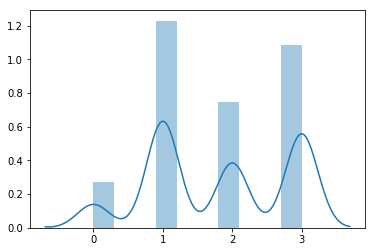

In [194]:
sns.distplot(list(df['Product']))

# Customer Age

Next we focused on plotting the distribution of Customer Age.

The plot seems to suggest that the data follows a bell shaped distribution. Most of the customers age between 0.3 and 0.8 (in the rescaled values).

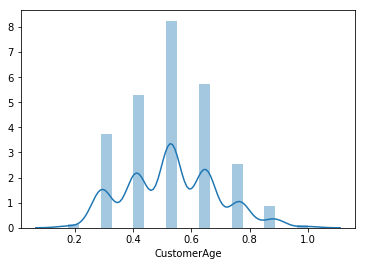

In [195]:
sns.distplot(df['CustomerAge'])

Here we wanted to plot the distribution of Customer Age for each product.

Hence we first grouped Customer Ages by product:

In [196]:
df[['CustomerAge', 'Product']].groupby(['CustomerAge'], as_index=False).mean().sort_values(by='Product', ascending=False)

,CustomerAge,Product
0,0.176471,2.333333
1,0.294118,2.055762
6,0.764706,1.818681
2,0.411765,1.792105
5,0.647059,1.782396
8,1.000000,1.777778
4,0.529412,1.714542
7,0.882353,1.500000
3,0.524722,1.441176


We now plot the distribution of Customer Age for each one of the 4 products on separate graphs.

Product 0 = V Camera

Product 1 = V Bag

Product 2 = V Auto

Product 3 = V Pet

The distributions are similar to the Customer Age distribution; we can see that every product has a higher concentration of customers centered around the range 0.45 and 0.65 (rescaled).

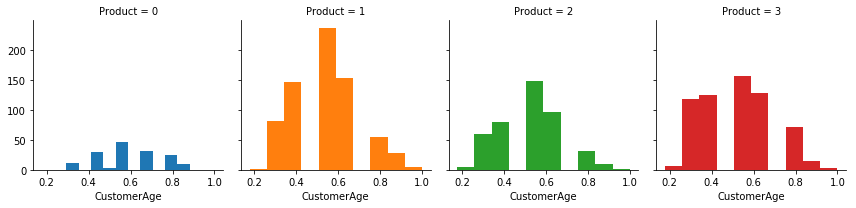

In [197]:
g = sns.FacetGrid(df, hue="Product", col='Product')
g.map(plt.hist, 'CustomerAge', bins=10)

## Data ARPU

In the following graph we plotted the ARPU (Average Revenue Per User) against the customer age; we can identify that users between age 0.4 and 0.8 have a higher ARPU than other customer age categories. <br>
However, a correlation between DataArpu and the Products is not prominent from this chart.

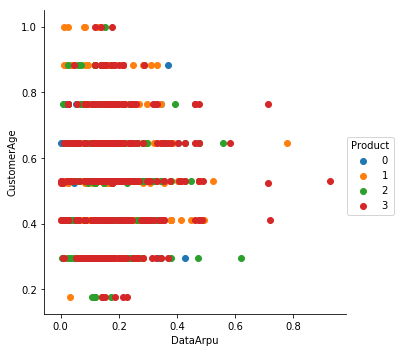

In [198]:
sns.FacetGrid(df, hue="Product", size=5) \
   .map(plt.scatter, "DataArpu", "CustomerAge") \
   .add_legend()

## Customer Gender

Here we wanted to focus on Customer Gender.

Hence we grouped Customer Gender by product just as we have done for Customer Age.

In [199]:
df[['CustomerGender', 'Product']].groupby(['CustomerGender'], as_index=False).mean().sort_values(by='Product', ascending=False)

,CustomerGender,Product
0,0.0,1.947627
1,1.0,1.722947


Here we plotted the Customer Gender for every product.
As we can see each product seems to have a higher prominence for Gender "1.0".

Just as a reminder: 

Product 0 = V Camera

Product 1 = V Bag

Product 2 = V Auto

Product 3 = V Pet

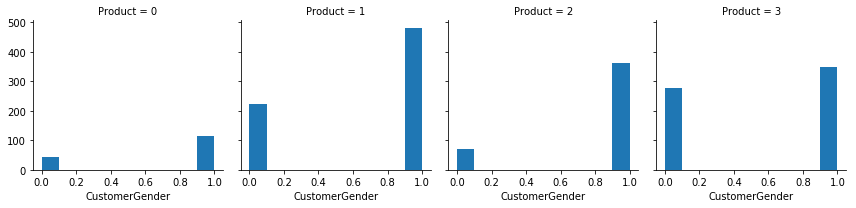

In [200]:
g = sns.FacetGrid(df, col='Product')
g.map(plt.hist, 'CustomerGender')

## Data Allowance

Here we wanted to analyze how Data Allowance was distributed among each product.

For every product Data Allowance seems to be skewed, concentrated around the "0.2" level.

Keep in mind that the DataAllowance column were rescaled between [0.0 - 1.0]

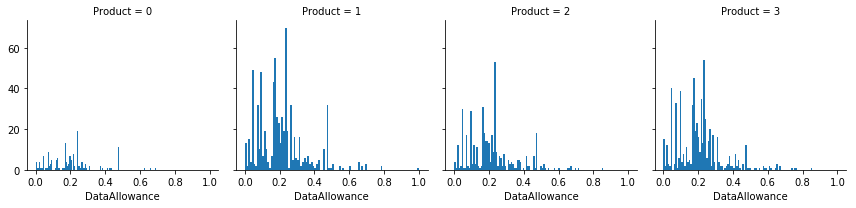

In [201]:
g = sns.FacetGrid(df, col='Product')
g.map(plt.hist, 'DataAllowance',bins = 100)

## Zipcode Plotting

In this part we focused on the geographical distribution of the zipcodes from the dataset. In particular we split the zipcodes by product in order to plot them on the Italian map, trying to infer any visual differences in concentration.

We imported the "latlong" CSV file that we found on the internet providing latitudes and longitudes corresponding to each Italian zipcode.

In [202]:
vod = pd.read_csv('latlong.csv', dtype='unicode')

In [203]:
vod.head()

,Unnamed: 0,Category,ZipCode,Latitude,Longitude
0,0,V-Camera,20010,45.5365,8.9894
1,1,V-Camera,73048,40.1759,18.0304
2,2,V-Camera,09134,39.2461,9.1278
3,3,V-Camera,34142,45.6486,13.78
4,4,V-Camera,32030,46.0891,11.9877


__"makefloat"__ Converts the values of the dataframe from string to float in order to plot them.

In [204]:
def makefloat(vod, k):
    vod[k] = vod[k].astype(float)

In [205]:
makefloat(vod, 'Longitude')
makefloat(vod, 'Latitude')

We have 106 V-Camera users, 587 V-bag users, 354 V-Auto users and 528 V-Pet users.

In [206]:
v_cam = vod[0:106]
v_bag = vod[107:693]
v_auto = vod[693: 1047]
v_pet = vod[1047:]

We decided to plot all the Zipcodes of the dataset. We can clearly see a concentration in the North of Italy and in the most important cities of the Southern part of the country, such as Rome and Naples, as we would expect.

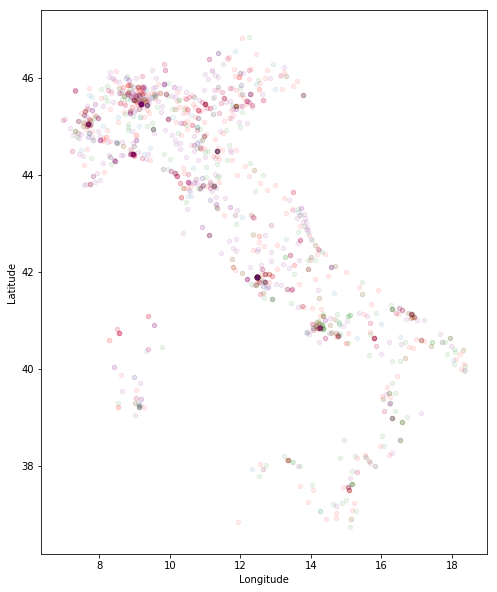

In [207]:
ax = v_cam.plot(kind='scatter', x='Longitude', y='Latitude', alpha=20/256, s=20, figsize=(10,10))
ax = v_bag.plot(kind='scatter', x='Longitude', y='Latitude', alpha=20/256, s=20, figsize=(10,10), ax=ax, color = 'red')
ax = v_auto.plot(kind='scatter', x='Longitude', y='Latitude', alpha=20/256, s=20, figsize=(10,10), ax=ax, color = 'green')
ax = v_pet.plot(kind='scatter', x='Longitude', y='Latitude', alpha=20/256, s=20, figsize=(8,10), ax=ax, color = 'purple')

We then focused on the geographical distribution of the individual products. By looking at these plots, it is clear that each product has a similar distribution: higher concentration in the North of Italy and in the important cities of the Southern part.

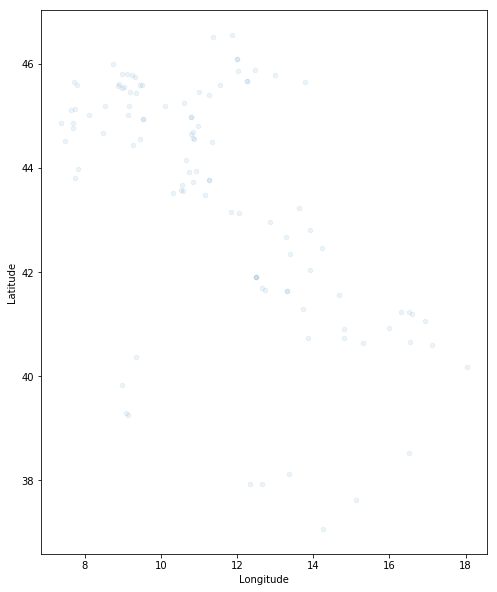

In [208]:
v_cam.plot(kind='scatter', x='Longitude', y='Latitude', alpha=20/256, s=20, figsize=(8,10))

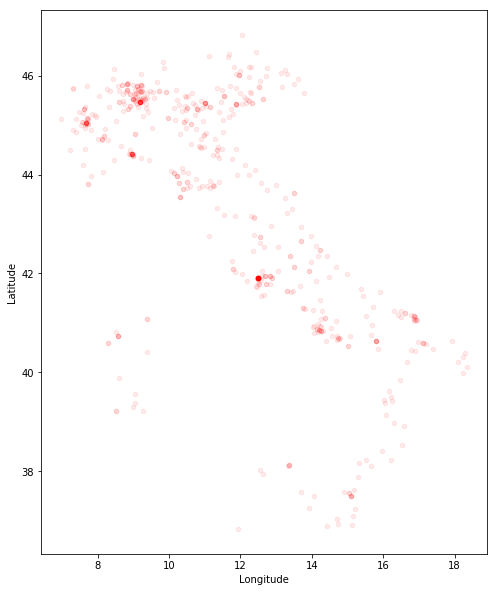

In [209]:
v_bag.plot(kind='scatter', x='Longitude', y='Latitude', alpha=20/256, s=20, figsize=(8,10), color = 'red')

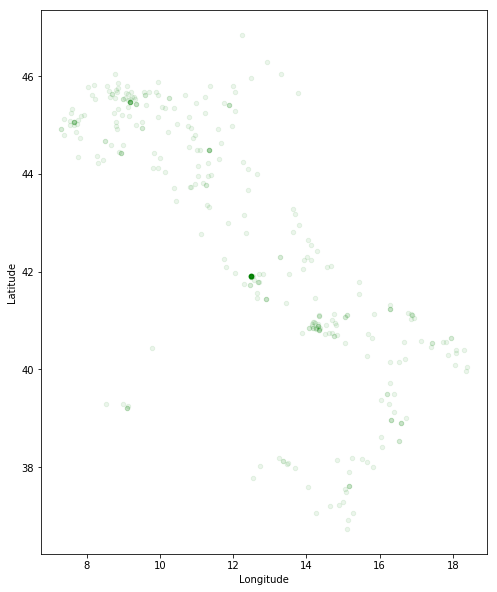

In [210]:
v_auto.plot(kind='scatter', x='Longitude', y='Latitude', alpha=20/256, s=20, figsize=(8,10), color = 'green')

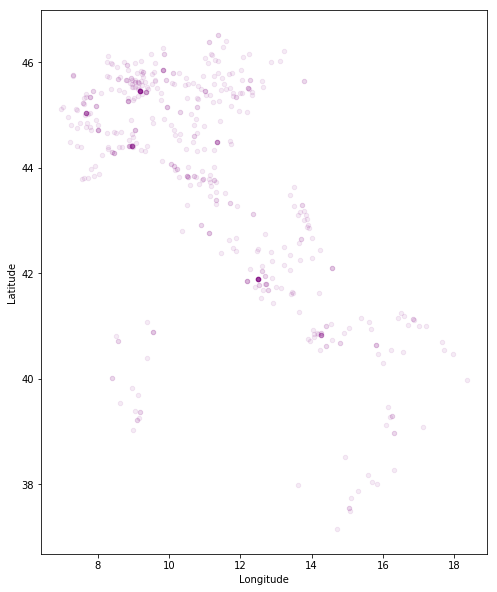

In [211]:
v_pet.plot(kind='scatter', x='Longitude', y='Latitude', alpha=20/256, s=20, figsize=(8,10), color = 'purple')

As we can see from these plots the products are sold following a similar pattern.

# 3. CLUSTERING & LEARNING 

## Data Preparation

We start by spliting the dataset in the test set (10%) and training set (90%).

In [212]:
t=0.9 
keep=['CustomerAge', 'CustomerGender', 'CustomerImmigrant', 'DataAllowance', 'DataArpu', 'DeviceFlag4G',
     'DeviceFlagSmartphone', 'iOS', 'Android', 'Other OS', 'Gdp', 'Shops', 'Urban', 'SemiUrban', 'Rural',
     'NorthEast', 'NorthWest', 'Center', 'South', 'Islands',
     'File-Transfer', 'Games', 'Instant-Messaging-Applications', 'Mail', 'MonthlyDataTraffic',
     'MonthlySmsTrafficCount', 'MonthlyVoiceTrafficCount', 'Music-Streaming', 'Network-Operation', 'P2P-Applications',
     'Security', 'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP', 'Web-Applications']

#df = pd.read_csv(path)
df = df[keep]
X = df.as_matrix().astype(float)

np.random.seed(100)
perm = np.random.permutation(Y.shape[0])
X, Y = X[perm], Y[perm]

t = int(Y.shape[0]*t)
X_train, X_test = X[:t], X[t:]
Y_train, Y_test = Y[:t], Y[t:]

These two functions convert a one hot vector into a numerical single value vector. <br>
The __"get_Y"__ function of the cleaning part returns a one hot vector. Depending on the usage, we might need to convert the Ys back and forth between one hot and single representation.

In [213]:
def single_to_onehot(y):
    try: 
        if(y.shape[1]>1): return Y
    except: pass
    Y = np.zeros((y.shape[0], 4))
    Y[np.arange(y.shape[0]), y.flatten()] = 1
    return Y

def onehot_to_single(Y):
    try: 
        if(Y.shape[1]==1): return Y
    except: return Y
    if(Y.shape[1]>0): Y = np.argmax(Y, axis=1).ravel()
    return Y

We convert the Ys from one hot representation to single value representation.

In [214]:
Y_train, Y_test = onehot_to_single(Y_train), onehot_to_single(Y_test)

__"get_error_stats"__ is an auxiliary function defined to give a better overview of our accuracy and performance of the algorithm. <br>
It outputs:
- A 4x4 grid stating the percentage of each catgeory predicted against the true category.
- The accuracy on each category. 
- The real and predicted proportions of the categories so that we can see if our algorithm is biased towards a category or another.
- Overall Accuracy.

It provides a more informative output compared to the simple __"score"__ function of the machine learning libraries.

In [215]:
def get_error_stats(P, Y, show = True):
    try:
        if(Y.shape[1]!=1): Y , P = onehot_to_single(Y), onehot_to_single(P)
    except:pass
    Y, P = Y.ravel(), P.ravel()
    correct = np.argwhere(P == Y)

    acc = correct.shape[0] / P.shape[0]
    acc = int(acc * 10000) / 10000

    if(show):
        comp = np.zeros((4,4))
        total = np.zeros((4,1))

        for i in range(Y.shape[0]):
            comp[int(P[i]),int(Y[i])] = comp[int(P[i]),int(Y[i])] + 1
            total[int(Y[i]),0] = total[int(Y[i]),0] + 1
        guessed_prop = (np.sum(comp, axis=1) / np.sum(comp) * 1000).astype(int) / 1000
        real_prop = (np.sum(comp, axis=0) / np.sum(comp) * 1000).astype(int) / 1000
        comp = comp / total
        comp = (comp*100).astype(int)/100
        print("---------------------------")
        print("      Correct Answer      ")
        print("    0     1     2     3   ")
        print("---------------------------")
        print(comp)
        print("---------------------------")
        print("Correctly Guessed:", [int(comp[i,i]*100)/100 for i in range(4)])
        print("Guessed Propotion:", guessed_prop)
        print("Actual Propotion: ", real_prop)

        print("Overall Accuracy:",acc)
        print("\n")

    return acc


Like we already saw in the visualization part, the categories are unbalanced: the proportions are respectively about 8%, 33%, 25%, 33%. <br>

It might be worth balancing the data in order to avoid ignoring the underepresented categories. The function __"balance"__ takes an optional parameter, "aim", which is a list of 4 elements of the final desired proportions. Each element corresponds to a category. <br>

If "aim" is not provided, the proportions are set equal by default.

In [216]:
def balance(X,Y, aim = None):
    Y = Y.ravel().reshape(-1,1)
    Yt = Y.ravel()
    c = Counter(Yt.flatten().tolist())
    if(aim==None):
        m = c.most_common(1)[0][1]
        aim = [m,m,m,m]
        
    print('UNBALANCED DATASET:', dict(c))

    Xt = [X[np.argwhere(Yt==0).ravel()], X[np.argwhere(Yt==1).ravel()], X[np.argwhere(Yt==2).ravel()], X[np.argwhere(Yt==3).ravel()]]
    Yt = [Y[np.argwhere(Yt==0).ravel()], Y[np.argwhere(Yt==1).ravel()], Y[np.argwhere(Yt==2).ravel()], Y[np.argwhere(Yt==3).ravel()]]
    
    prop = [Xt[0].shape[0], Xt[1].shape[0], Xt[2].shape[0], Xt[3].shape[0]]
    print("Prop:", prop)
    print("Aim: ", aim)
    x, y = [], []

    for i in range(4):
        needed = int(aim[i]/prop[i])
        for _ in range(int(needed)):
            x.append(Xt[i])
            y.append(Yt[i])

        extra_needed = aim[i]%(prop[i]*needed)
        p = np.random.permutation(prop[i])[:extra_needed]
        x.append(Xt[i][p])
        y.append(Yt[i][p])

    X = np.vstack(x)
    Y = np.vstack(y)
    c = Counter(Y.flatten().tolist())
    print('BALANCED DATASET:', dict(c) ,"\n")

    return X, Y

## PCA

We first decided to run PCA.

As we can see, PCA is not really helpful for dimensionality reduction: the most important component only explains about 16% of the variance. 
We ran several tests with and without PCA and concluded that it wasn't useful. Thus we decided to proceed without principle component analysis.

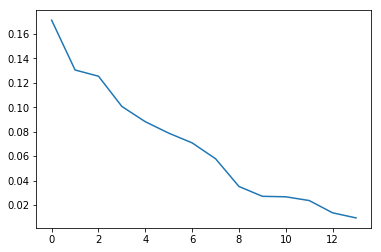

In [217]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_)

## KNearestNeighbors

We now start the learning. <br>

We first implemented KNearestNeighbors algorithm with scikitlearn.

In [218]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

P_train, P_test = knn.predict(X_train), knn.predict(X_test)
tr_acc = get_error_stats(P_train, Y_train)
te_acc = get_error_stats(P_test, Y_test, show = True)

print("Train Accuracy: ", tr_acc)
print("Test Accuracy: ", te_acc)

---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.25 0.06 0.11 0.11]
 [0.09 0.72 0.23 0.3 ]
 [0.05 0.15 0.48 0.16]
 [0.05 0.18 0.06 0.51]]
---------------------------
Correctly Guessed: [0.25, 0.72, 0.48, 0.51]
Guessed Propotion: [0.045 0.494 0.193 0.265]
Actual Propotion:  [0.083 0.365 0.224 0.325]
Overall Accuracy: 0.565


---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.   0.27 0.09 0.  ]
 [0.07 0.5  0.3  0.4 ]
 [0.06 0.37 0.3  0.3 ]
 [0.03 0.3  0.09 0.29]]
---------------------------
Correctly Guessed: [0.0, 0.5, 0.3, 0.28]
Guessed Propotion: [0.02  0.51  0.234 0.234]
Actual Propotion:  [0.057 0.395 0.223 0.322]
Overall Accuracy: 0.3593


Train Accuracy:  0.565
Test Accuracy:  0.3593


The first try is unsurprisingly not a success. It is probably due to the fact that we assumed all features to be equally important. <br>
- We implemented simulated annealing to get the optimal weights in order to maximize accuracy. 
- We intitialized the ratios to ones (all features equally important). 
- We generated a 36 dimensional random step. A step corresponds to an increase / decrease in individual weight of 20%, or keeping it unchanged. 
- We then decide whether or not to keep the step using the standard simulated annealing approach. 
In the present code we iterated 10 times due to time contraints, but we actually ran it about 50,000 times, storing the weights in a seperate file __(weights.npy)__

In [219]:
def find_wieghts():
    n = X_train.shape[1]
    i=0
    temprature=0.9
    max_acc = 0
    ratios = np.ones(n)
    possible_steps = [0.8,1,1.2]

    for i in range(10):

         step = np.ones((1, n))
         #step[0, np.random.randint(low=0, high=n)] = np.random.choice(possible_steps)#.reshape(1,-1)
         step = np.random.choice(possible_steps,n).reshape((1,n))
         r = ratios*step

         X_tra = X_train*ratios
         X_tes = X_test*ratios

         knn = KNeighborsClassifier(n_neighbors=5,)
         knn.fit(X_tra, Y_train)
         te_acc = get_error_stats(knn.predict(X_tes) ,Y_test, show=False)
         tr_acc = get_error_stats(knn.predict(X_tra) ,Y_train, show=False)

         ran = np.random.random()+(te_acc-max_acc)*2
         if(te_acc>max_acc or ran>temprature):
            ratios = r
            max_acc = te_acc
            print(str(i)+":",tr_acc , te_acc)

         if(i%10==0):
             if(temprature<0.95): temprature=temprature+0.01

    return r

r = find_wieghts()

0: 0.565 0.3593
2: 0.5528 0.3541


We load the "weights" file

In [220]:
weights = np.load("weights.npy")
print(weights)

[[0.52183853 1.62312655 0.692534   1.94775186 0.2226511  0.52183853
  0.90173697 0.83104079 0.41747082 0.86566749 0.90173697 0.26718133
  1.03880099 0.48092639 0.29548117 1.62312655 1.69075683 0.75144748
  0.50096499 1.62312655 1.12717122 0.83104079 0.72138958 0.27831388
  0.5540272  1.35260546 1.76120503 0.62620623 0.72138958 3.17016905
  1.35260546 1.08208437 1.76120503 0.90173697 0.93930935 0.8153727 ]]


We ran KNearestNeighbors again after applying the custom weights from the "weights.npy" file with the number of neighbors equal to 5

In [221]:
X_tr = X_train*weights
X_te = X_test*weights

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, Y_train)

P_train, P_test = knn.predict(X_tr), knn.predict(X_te)
tr_acc = get_error_stats(P_train, Y_train)
te_acc = get_error_stats(P_test, Y_test, show = True)

print("Train Accuracy: ", tr_acc)
print("Test Accuracy: ", te_acc)

---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.29 0.12 0.09 0.13]
 [0.09 0.72 0.23 0.29]
 [0.05 0.17 0.49 0.23]
 [0.03 0.15 0.06 0.47]]
---------------------------
Correctly Guessed: [0.28, 0.72, 0.49, 0.47]
Guessed Propotion: [0.054 0.491 0.216 0.238]
Actual Propotion:  [0.083 0.365 0.224 0.325]
Overall Accuracy: 0.5563


---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.09 0.18 0.27 0.  ]
 [0.05 0.51 0.27 0.43]
 [0.11 0.34 0.34 0.25]
 [0.01 0.32 0.06 0.29]]
---------------------------
Correctly Guessed: [0.09, 0.51, 0.34, 0.28]
Guessed Propotion: [0.031 0.505 0.239 0.223]
Actual Propotion:  [0.057 0.395 0.223 0.322]
Overall Accuracy: 0.3802


Train Accuracy:  0.5563
Test Accuracy:  0.3802


## K-Means

A small increase in accuracy is observed. This however is not enough. Based on our experimentation, this approach is helpful but sometimes too volatile. <br>
We now have a better idea about the actual importance of the features. Perhaps we could implement KMeans for clustering and find a projection of the clusters onto the four categories. First we write a fucntion that projects the clusters onto our categories.

The function __"projection"__ finds the most prominent category in each cluster. It then assigns the categories to the corresponding cluster. 

For example if the category 0 is the most prominent in cluster 13, we project cluster 13 onto category 0.

The function returns a list of length equal to the number of clusters with the projections (the first element of the list is the category assigned to the first cluster).

In [222]:
def projection(X_train, Y_train, km, n):
    projection = [0 for _ in range(n)]
    P = km.predict(X_train).ravel()
    for i in range(n):
        Y = list(Y_train[np.argwhere(P==i)].ravel())
        try:    m = Counter(Y).most_common(1)[0][0]
        except: m = 10
        projection[i] = m

    return projection

The function __"predict"__ predicts one cluster for each data point and then maps it to the category using the projection list.  

Continuing our previous example, this means every time the algorithm predicts cluster 13, the raw prediction gets mapped to category 0 and so on.

In [223]:
def predict(X, projections, km):
    p = km.predict(X).ravel()
    for i in range(len(p)):
        p[i] = projections[p[i]]
    return p

This next section proves that 25 is the optimal number of clusters. The outcome is different every time that the code is run, but the number that consistently performs best is 25.

Ideal number of Clusters: 45


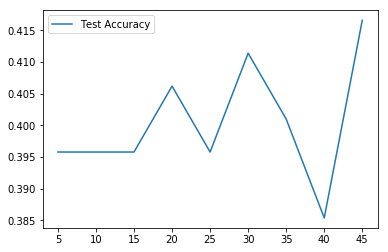

In [224]:
X_tr = X_train*weights
X_te = X_test*weights

c = [n for n in range(5,50,5)]
te_accs = []
for n in c:
    np.random.seed(10)
    km = KMeans(n_clusters = n)
    km.fit(X_tr)

    projections = projection(X_tr, Y_train, km, n)

    [P_train] = predict(X_tr, projections, km),
    P_test = predict(X_te, projections, km)

    tr_acc = get_error_stats(P_train, Y_train, show = False)
    te_acc = get_error_stats(P_test, Y_test, show = False)
    
    te_accs.append(te_acc)

plt.plot(c, te_accs, label = "Test Accuracy")
plt.legend()
ideal_n = c[np.argmax(te_accs)]
print("Ideal number of Clusters:",ideal_n)

Now that we have the appropriate auxilary function, we can implement the K-Means algorithm. 

We set the number of cluster to 25 as we found that it maximizes the performance of the algorithm.

In [225]:
X_tr = X_train*weights
X_te = X_test*weights

np.random.seed(10)
n = 25
km = KMeans(n_clusters = n)
km.fit(X_tr)

projections = projection(X_tr, Y_train, km, n)
print("The projections are: ",projections,"\n")

[P_train] = predict(X_tr, projections, km),
P_test = predict(X_te, projections, km)

tr_acc = get_error_stats(P_train, Y_train, show = True)
te_acc = get_error_stats(P_test, Y_test, show = True)

print("Train Accuracy: ", tr_acc)
print("Test Accuracy: ", te_acc)


The projections are:  [1, 1, 2, 3, 1, 1, 3, 1, 1, 2, 3, 1, 2, 1, 1, 3, 2, 3, 1, 2, 1, 1, 1, 3, 3] 

---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.   0.   0.   0.  ]
 [0.12 0.55 0.3  0.41]
 [0.06 0.29 0.36 0.19]
 [0.07 0.29 0.09 0.4 ]]
---------------------------
Correctly Guessed: [0.0, 0.55, 0.36, 0.4]
Guessed Propotion: [0.    0.51  0.208 0.281]
Actual Propotion:  [0.083 0.365 0.224 0.325]
Overall Accuracy: 0.4186


---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.   0.   0.   0.  ]
 [0.05 0.46 0.3  0.39]
 [0.09 0.37 0.27 0.06]
 [0.04 0.4  0.12 0.46]]
---------------------------
Correctly Guessed: [0.0, 0.46, 0.27, 0.46]
Guessed Propotion: [0.    0.479 0.182 0.338]
Actual Propotion:  [0.057 0.395 0.223 0.322]
Overall Accuracy: 0.3958


Train Accuracy:  0.4186
Test Accuracy:  0.3958


We would like to view how well the clusters fit our data. 

The function __"visualize_proportions"__ prints the proportions of each category in each cluster.

Ideally we would want to have clusters comprising just one category. That is,  we want the proportion of one category to be 1.0 and  the proportions of the rest be zero.  

In [226]:
def visualize_proportions(X_train, Y_train, km, n):
    projection = [0 for _ in range(n)]
    P = km.predict(X_train).ravel()
    print("Category:     1    2    3    4 ")
    print("---------------------------------")
    for i in range(n):
        Y = list(Y_train[np.argwhere(P==i)].ravel())
        c = Counter(Y)
        total = c[0]+c[1]+c[2]+c[3]
        print("Cluster",str(i)+": ",round(c[0]/total,2), round(c[1]/total,2), round(c[2]/total,2), round(c[3]/total,2))

In [227]:
visualize_proportions(X_tr, Y_train, km, n)

Category:     1    2    3    4 
---------------------------------
Cluster 0:  0.07 0.43 0.29 0.21
Cluster 1:  0.08 0.36 0.27 0.3
Cluster 2:  0.11 0.29 0.39 0.2
Cluster 3:  0.07 0.33 0.07 0.53
Cluster 4:  0.03 0.41 0.22 0.34
Cluster 5:  0.1 0.44 0.06 0.4
Cluster 6:  0.09 0.39 0.11 0.41
Cluster 7:  0.17 0.39 0.16 0.28
Cluster 8:  0.06 0.39 0.17 0.38
Cluster 9:  0.11 0.33 0.37 0.2
Cluster 10:  0.08 0.31 0.08 0.53
Cluster 11:  0.12 0.4 0.21 0.27
Cluster 12:  0.06 0.3 0.42 0.22
Cluster 13:  0.07 0.41 0.22 0.31
Cluster 14:  0.12 0.45 0.23 0.2
Cluster 15:  0.11 0.27 0.09 0.53
Cluster 16:  0.06 0.34 0.38 0.22
Cluster 17:  0.08 0.38 0.11 0.43
Cluster 18:  0.08 0.45 0.29 0.18
Cluster 19:  0.0 0.38 0.44 0.18
Cluster 20:  0.14 0.35 0.32 0.19
Cluster 21:  0.03 0.4 0.24 0.33
Cluster 22:  0.07 0.44 0.15 0.34
Cluster 23:  0.11 0.34 0.17 0.38
Cluster 24:  0.03 0.4 0.13 0.44


The KMean algorithm yields a reasonable accuracy especially after using the custom weights. After cross validating with different Train/Test sets, we can confidently say it is the best unsupervised learning method for the given dataset. It consistently outperforms KNearestNeighbours and a system of stacked autoencoders.

Considering that we have the labels available for the data points, it is worth implementing some supervised learning techniques and see if they improve performance.

We tried Logisitic Regression, DecisionTrees,  Perceptrons,  Multilevel Perceptrons and Neural Networks.

We settled on Neural networks as they proved to be the best option. Since we were not able to use their full potential and flexibility from scikit learn, we decided to use another library. We opted for a custom neural network class using tensorflow. 

##  Custom neural network

We have tried to keep the functionality of this class as close as possible to the scikitlearns native classes. 
- The nueral network object takes six parameters architecture: X_train / Y_train / X_test / Y_test / top. 
- The architecture is the list containing the sizes of the hidden layers. 
         - [100] would mean a neural network with a single hidden layer of 100 units. 
         - [ ] would mean a shallow network without any hidden layers.
         - [100,100,100] would mean three hidden layers of a 100 units each. 
         - Only up to three hidden leayer can be implemented with this class.
- The __"top"__ parameter takes an integer ranging from 1-4. Instead of only getting one answer we get a vector of the first (top) most likely answers in descending order and their confidence. The default value for this parameter is 1.
        - If top=1, it returns the most likely answer. 
        - If top=2 it returns the two most likely answers with descending confidence. 
- The __"fit"__ function trains the neural network. It takes as parameters: learning_rate=0.1 , epochs=5000, alpha=0.01 and verbose=True. Alpha is the regularization multiple, the others are self explanatory. 
- The __"get_error_stat"__ function is a simple scoring function like the scikitlearn native score function.
- The __"predict"__ function makes the prediction for a datapoint.
- It is possible to pass the different __"top"__ parameter in all of the functions of the class mentioned above. If you choose not to, it will default to the __"top"__ parameter originally provided when the neural network object was created.

In [228]:
class nueral_net:
    
    def __init__(self, architecture, X_train, Y_train, X_test, Y_test, top=1):
        tf.reset_default_graph()
        self.X_train = X_train 
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.top = top

        self.m, self.inp = X_train.shape
        _, self.output = Y_train.shape
        self.architecture = architecture
        self.layers = len(architecture)
        
        self.x = tf.placeholder(tf.float32, [None, self.inp], name = "x")
        self.y = tf.placeholder(tf.float32, name = "y")
            
    def model(self,x):

        try:
            self.hidden_1 = {"W":tf.Variable(tf.random_normal([self.inp, self.architecture[0]]), name = "w1"),
                             "b":tf.Variable(tf.random_normal([self.architecture[0]]), name = "b1")}
            self.hidden_2 = {"W":tf.Variable(tf.random_normal([self.architecture[0], self.architecture[1]]), name = "w2"),
                             "b":tf.Variable(tf.random_normal([self.architecture[1]]), name = "b2")}
            self.hidden_3 = {"W":tf.Variable(tf.random_normal([self.architecture[1], self.architecture[2]]), name = "w3"),
                             "b":tf.Variable(tf.random_normal([self.architecture[2]]), name = "b3")}
        except: pass

        try: self.out = {"W": tf.Variable(tf.random_normal([self.architecture[-1], self.output]), name="wout"),
                         "b": tf.Variable(tf.random_normal([self.output]), name="bout")}
        except: self.out = {"W": tf.Variable(tf.random_normal([self.inp, self.output]), name="wout"),
                         "b": tf.Variable(tf.random_normal([self.output]), name="bout")}

        if (self.layers >= 1):
            l = tf.add(tf.matmul(x, self.hidden_1["W"]), self.hidden_1["b"])
            l = tf.nn.tanh(l)

            if (self.layers >= 2):
                l = tf.add(tf.matmul(l, self.hidden_2["W"]), self.hidden_2["b"])
                l = tf.nn.tanh(l)

                if (self.layers >= 3):
                    l = tf.add(tf.matmul(l, self.hidden_3["W"]), self.hidden_3["b"])
                    l = tf.nn.tanh(l)

        if (self.layers >= 1): l = tf.add(tf.matmul(l, self.out["W"]), self.out["b"])
        else: l = tf.add(tf.matmul(x, self.out["W"]), self.out["b"])

        out = tf.nn.sigmoid(l)

        return out
    
    def fit(self, learning_rate=0.1 , epochs=5000, alpha=0.001, verbose=True):
        self.predictions = self.model(self.x)

        regularization = tf.norm(self.out["W"])+tf.norm(self.out["b"])
        if (self.layers >= 1): regularization = regularization + tf.norm(self.hidden_1["W"]) + tf.norm(self.hidden_1["b"])
        if (self.layers >= 2): regularization = regularization + tf.norm(self.hidden_2["W"]) + tf.norm(self.hidden_2["b"])
        if (self.layers >= 3): regularization = regularization + tf.norm(self.hidden_3["W"]) + tf.norm(self.hidden_3["b"])
   
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.predictions, labels = self.y )) + alpha*regularization
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)  #learning_rate
        
        self.sess =  tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        train_accs = []
        test_accs =  []
        loss = []
        
        for epoch in range(epochs+1):
            _ , c = self.sess.run([optimizer, cost], feed_dict={self.x:self.X_train, self.y:self.Y_train})

            if(epoch%100==0 and verbose):
                print("Epoch:",epoch,"  Cost:",c, end= "  ")
                print("Train: ",self.get_error_stats(self.X_train, self.Y_train), end= "  ")
                print("Test: ", self.get_error_stats(self.X_test, self.Y_test))
            if(epoch>100 and self.get_error_stats(self.X_test, self.Y_test)>0.41 and self.get_error_stats(self.X_test, self.Y_test)<self.get_error_stats(self.X_train, self.Y_train)): 
                print("Epoch:",epoch,"  Cost:",c, end= "  ")
                print("Train: ",self.get_error_stats(self.X_train, self.Y_train), end= "  ")
                print("Test: ", self.get_error_stats(self.X_test, self.Y_test))
                break
            
            train_accs.append(self.get_error_stats(self.X_train, self.Y_train))
            test_accs.append(self.get_error_stats(self.X_test, self.Y_test))
            loss.append(c)
        
        plt.plot(train_accs, label = "train")
        plt.plot(test_accs, label = "test")
        plt.legend()
        plt.show()
        plt.plot(loss, label = "loss")
        plt.legend()
                             
        return self
    
    def get_error_stats(self, X, Y, top=None):
        [P] = self.sess.run([self.predictions], feed_dict={self.x: X})
        P = np.fliplr(np.argsort(P, axis=1))
        Y = np.argmax(Y, axis=1).ravel()

        if(top==None): top = self.top
        correct = np.equal(P[:,0],Y)
        if (top>=2): correct = np.logical_or(correct, np.equal(P[:,1], Y))
        if (top>=3): correct = np.logical_or(correct, np.equal(P[:,2], Y))
        if (top>=4): correct = np.logical_or(correct, np.equal(P[:,3], Y))

        acc = np.mean(correct)
        acc = round(acc, 2)

        return acc

    def predict(self, X, top = None):
        if(top == None): top = self.top
        [P] = self.sess.run([self.predictions], feed_dict={self.x: X})
        P = P.reshape((X.shape[0], 4))
        args = np.fliplr(np.argsort(P, axis=1)).reshape(P.shape)
        #args = np.argmax(P, axis=1)
        for i in range(len(P)):
            P[i] = P[i][args[i]]

        args, P = args[:,0:top], P[:,0:top]

        return args, P


The neural network is much more sensitive to imbalanced classes compared to the clustering algorithms explained above. 

It is a good idea to balance the classes using the __"balance"__ function defined earlier. The target we chose is 450, 650, 600, 600

In [229]:
X_tr, Y_tr = balance(X_train,Y_train, aim=[450, 650, 600 ,600 ])

UNBALANCED DATASET: {1: 630, 0: 144, 3: 561, 2: 387}
Prop: [144, 630, 387, 561]
Aim:  [450, 650, 600, 600]
BALANCED DATASET: {0: 450, 1: 650, 2: 600, 3: 600} 



It is worth noting that the neural network works with the one hot representaion of the Ys. <br> 
We convert the single valued Ys into one hot representations with the function defined earlier. 

In [230]:
Y_tr = single_to_onehot(Y_tr)
Y_te = single_to_onehot(Y_test)

We make a neural network with one hidden layer. The network has the following features
- 100 units in the hidden layer.
- The activation function used is __tanh__ for the hidden layer and __sigmoid__ for the output layer.
- Alpha, the regularization multiple, is set to 0.001.
- The learning rate is set to 0.1
- The optimizing algorithm used is __Adam__.
- The cost function used is the __Softmax Cross Entropy__

## Train  /  Test  /  Loss Function

In the following section we plotted the training and testing accuracy, along with the loss function. 

Epoch: 0   Cost: 1.5343093  Train:  0.3  Test:  0.4
Epoch: 100   Cost: 1.1919829  Train:  0.57  Test:  0.39
Epoch: 113   Cost: 1.1813265  Train:  0.59  Test:  0.42


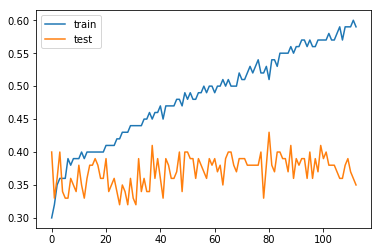

---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.37 0.02 0.03 0.02]
 [0.2  0.66 0.18 0.23]
 [0.08 0.11 0.63 0.11]
 [0.16 0.22 0.14 0.62]]
---------------------------
Correctly Guessed: [0.37, 0.66, 0.63, 0.62]
Guessed Propotion: [0.088 0.363 0.246 0.301]
Actual Propotion:  [0.195 0.282 0.26  0.26 ]
Overall Accuracy: 0.5891


---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.   0.45 0.18 0.  ]
 [0.06 0.48 0.28 0.32]
 [0.11 0.3  0.3  0.16]
 [0.01 0.33 0.09 0.48]]
---------------------------
Correctly Guessed: [0.0, 0.48, 0.3, 0.48]
Guessed Propotion: [0.036 0.463 0.197 0.302]
Actual Propotion:  [0.057 0.395 0.223 0.322]
Overall Accuracy: 0.4166




0.4166

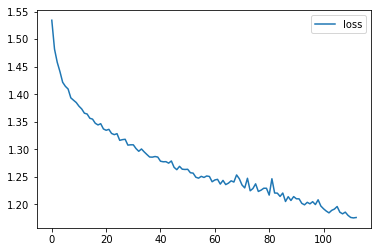

In [231]:
architecture = [100]
nn = nueral_net(architecture, X_tr, Y_tr, X_test, Y_te, top=1)
nn.fit(learning_rate=0.1 , epochs=10000, alpha=0.001, verbose=True)

P, prop = nn.predict(X_tr)
get_error_stats(P, onehot_to_single(Y_tr))
P, prop = nn.predict(X_test)
get_error_stats(P, onehot_to_single(Y_te))


We are also able to get more than one answer and their corresponding confidence. In the following box, we demonstrate how to get the top 1, 2 and 4 (all answers) for 1 users of the training set.

TOP 1 Category

In [232]:
P, prop = nn.predict(X_tr[0:1], top=1)
print(P)
print(prop)

[[1]]
[[0.03235121]]


TOP 2 Categories

In [236]:
P, prop = nn.predict(X_tr[0:1], top=2)
print(P)
print(prop)

[[0 1]]
[[0.99852693 0.00195447]]


TOP 4 Categories

In [1]:
P, prop = nn.predict(X_tr[0:1], top=4)
print(P)
print(prop)

NameError: name 'nn' is not defined

Let us provide a concrete example.

Suppose you have 100 dollars to spend on 1 user for advertising, you could use the confidence levels we provided in the above output to allocate the correct proportions for each category. 

Another thing worth remembering is the possibility to add a flexible "aim" in the balancing function. <br>
A change in proportions translates into a change in the final answers. By doing so we can control the categories that the algorithm is biased towards. <br>
In our experience aim=[450, 650, 600 ,600] is best for unbiasedness. 

However we might want to lean towards one category rather than another. (That is, we would prefer making an error in favour of one category rather than another. We would sacrifice a bit of accuracy in order to make sure we didn't miss the desired category). 

For example, if category 0 is much more lucrative for Vodafone and they want a bias towards this category, "aim" would be changed to [750, 650, 600 ,600]. We set the number of examples of category 0 starting from 450 (unbiased case) up to 750.

UNBALANCED DATASET: {1: 630, 0: 144, 3: 561, 2: 387}
Prop: [144, 630, 387, 561]
Aim:  [750, 650, 600, 600]
BALANCED DATASET: {0: 750, 1: 650, 2: 600, 3: 600} 

Epoch: 0   Cost: 1.5973253  Train:  0.25  Test:  0.27
Epoch: 100   Cost: 1.2225163  Train:  0.45  Test:  0.38
Epoch: 121   Cost: 1.1956509  Train:  0.5  Test:  0.42


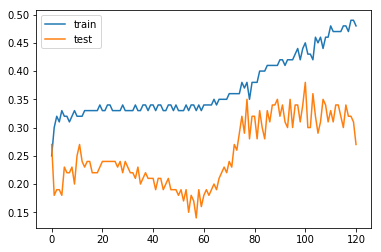

---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.49 0.05 0.08 0.06]
 [0.2  0.58 0.32 0.26]
 [0.16 0.15 0.38 0.11]
 [0.23 0.22 0.16 0.51]]
---------------------------
Correctly Guessed: [0.49, 0.57, 0.38, 0.51]
Guessed Propotion: [0.205 0.343 0.189 0.261]
Actual Propotion:  [0.288 0.25  0.23  0.23 ]
Overall Accuracy: 0.4965


---------------------------
      Correct Answer      
    0     1     2     3   
---------------------------
[[0.27 0.81 0.63 0.27]
 [0.06 0.48 0.22 0.34]
 [0.04 0.2  0.27 0.11]
 [0.01 0.33 0.11 0.45]]
---------------------------
Correctly Guessed: [0.27, 0.48, 0.27, 0.45]
Guessed Propotion: [0.114 0.442 0.145 0.296]
Actual Propotion:  [0.057 0.395 0.223 0.322]
Overall Accuracy: 0.4166




0.4166

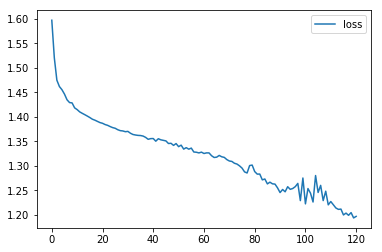

In [235]:
X_tr, Y_tr = balance(X_train,Y_train, aim=[750, 650, 600 ,600 ])

Y_tr = single_to_onehot(Y_tr)
Y_te = single_to_onehot(Y_test)

architecture = [100]
nn = nueral_net(architecture, X_tr, Y_tr, X_test, Y_te, top=1)
nn.fit(learning_rate=0.1 , epochs=10000, alpha=0.001, verbose=True)

P, prop = nn.predict(X_tr)
get_error_stats(P, onehot_to_single(Y_tr))
P, prop = nn.predict(X_test)
get_error_stats(P, onehot_to_single(Y_te))


The overall accuracy may be impacted. However, the specific accuracy and guessed proportion for category 0 increases. This way, the false negatives for category 0 decrease. <br>
On the other hand the false positives increase. Therefore, there is a tradeoff. <br>
Since the overall accuracy seems to be relatively low, around 42-44%, the effect of this feature tends to be volatile. 
Because the desired effect might not be easily achieved, this feature should be used with caution.

# CONLUSION

To conclude our analysis, by experimenting both Neural Networks and Kmeans, we found out that kmeans yielded a good level of accuracy compared to other unsupervised methods, especially after implementing it with custom weights. <br>
Given the fact that we were given labeled data, we used Neural networks as a supervised method. This gave us the best accuracy, and was also able to explain additional aspects of the data. <br>
We must say that in absolute terms, the achieved accuracy is low. Therefore the main takaways of our analysis need to be taken with caution. <br>

We are certain that the 4 products are mostly sold in the major Italian cities (Milan, Turin, Rome, Naples). <br>
Moreover we can confidently say that the products are more successful in the northern part of the country. It might be because there are more people living in this area or that they are more appealing to them. <br>
Hence for marketing purposes, targeting these 4 cities and the northen part of Italy makes sense because they are more responsive markets. <br>

Furthermore, marketing campaigns for the south of Italy should be designed in a different manner, the population needs to feel more involved and represented. Consequently they might be willing to try out the product, because given the data, we noticed fewer purchases in this geographical area. <br>

Additionally our insights from the clustering could be improved by using a larger and especially detailed dataset with characterstics such as criminality rates of where the clients live (they might be willing to try V-Auto or V-Camera), whether clients own a pet or not (for V-pet), what their hobbies and passions are. This would give a clear overview of the client's personality and the products that he might need.